## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
from keras.regularizers import l1,l2,l1_l2
from keras.layers import Dropout, BatchNormalization
# Disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256], l1_ratio=1e-4, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = [32, 128]
MOMENTUM = 0.95

In [7]:
results = {}

for b_size in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=b_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    
    results[str(b_size)] = {'train_loss': train_loss,
                        'valid_loss': valid_loss,
                        'train_acc': train_acc,
                        'valid_acc': valid_acc}





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_______________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 36s 724us/step - loss: 5.6994 - acc: 0.3354 - val_loss: 5.3222 - val_acc: 0.4235
Epoch 2/20
50000/50000 [==============================] - 32s 637us/step - loss: 5.2867 - acc: 0.4149 - val_loss: 5.1775 - val_acc: 0.4176
Epoch 3/20
50000/50000 [==============================] - 35s 706us/step - loss: 5.0740 - acc: 0.4392 - val_loss: 4.9614 - val_acc: 0.4524
Epoch 4/20
50000/50000 [==============================] - 39s 770us/step - loss: 4.8991 - acc: 0.4584 - val_loss: 4.8059 - val_acc: 0.4648
Epoch 5/20
50000/50000 [==============================] - 36s 726us/step - loss: 4.7372 - acc: 0.4709 - val_loss: 4.6936 - val_acc: 0.4606
Epoch 6/20
50000/50000 [==============================] - 35s 701us/step - loss: 4.5969 - acc: 0.4800 - val_loss: 4.5605 - val_acc: 0.4748
Epoch 7/20
50000/50000 [==============================] - 38s 755us/step - loss: 4.4655 - acc: 0.4861 - val_loss: 4.

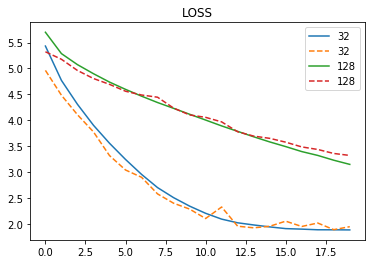

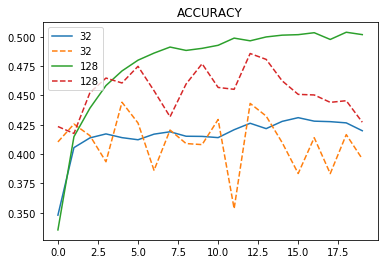

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

for i,n in enumerate(results.keys()):
    plt.plot(range(len(results[n]['train_loss'])), results[n]['train_loss'], '-', label=n)
    plt.plot(range(len(results[n]['valid_loss'])), results[n]['valid_loss'], '--', label=n)
    plt.legend()
    plt.title('LOSS')
plt.show()

for i,n in enumerate(results.keys()):
    plt.plot(range(len(results[n]['train_acc'])), results[n]['train_acc'], '-', label=n)
    plt.plot(range(len(results[n]['valid_acc'])), results[n]['valid_acc'], '--', label=n)
    plt.legend()
    plt.title('ACCURACY')
plt.show()